In [50]:
import pandas as pd

# Read the CSV file
file_path = '../preped.csv'
df = pd.read_csv(file_path)

In [51]:
print(df.columns)

Index(['Title', 'Is Series', 'Hidden Gem Score', 'Runtime', 'IMDb Score',
       'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received',
       'Awards Nominated For', 'Boxoffice', 'Release Date', 'IMDb Votes',
       'Minimum Age', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance',
       'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')


In [52]:
df['Release Date']

0       1614816000
1       1614816000
2       1614729600
3       1614729600
4       1614729600
           ...    
2504    1428969600
2505    1428969600
2506    1428969600
2507    1428969600
2508    1428969600
Name: Release Date, Length: 2509, dtype: int64

In [53]:
# Define age groups
def age_group(age):
    if age == 0:
        return 'All'
    elif 1 <= age <= 16:
        return 'Teen'
    else:
        return 'Adult'
df['Age Group'] = df['Minimum Age'].apply(age_group)

df['Age Group']

0       Adult
1       Adult
2       Adult
3        Teen
4        Teen
        ...  
2504     Teen
2505     Teen
2506     Teen
2507     Teen
2508     Teen
Name: Age Group, Length: 2509, dtype: object

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, accuracy_score

# Define the feature columns and target column
features = df.drop(columns=['Minimum Age', 'Age Group']).select_dtypes(include=[int, float])
target_column = 'Age Group'

# Separate the features and target variable
X = features
y = df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.7151394422310757


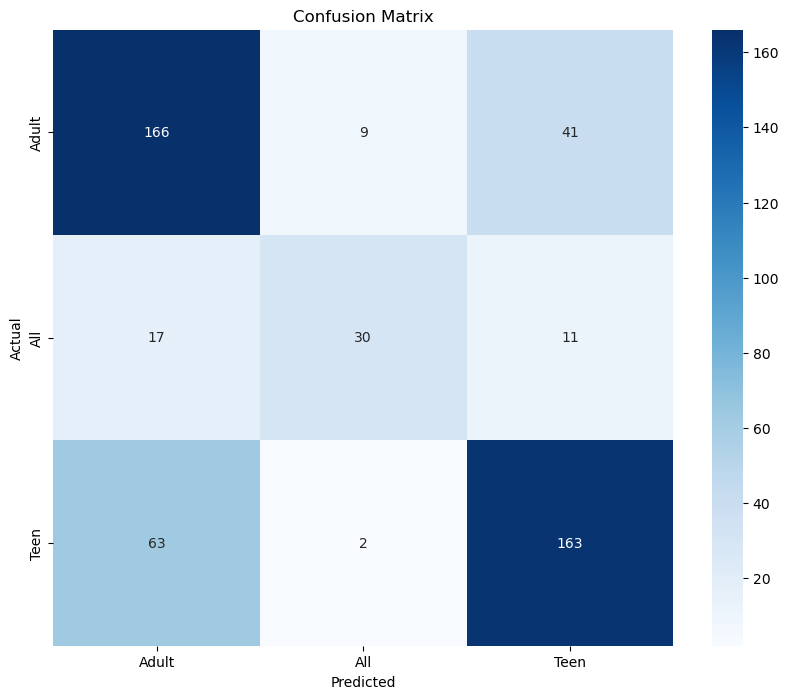

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap of confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Adult', 'All', 'Teen'],
            yticklabels=['Adult', 'All', 'Teen'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

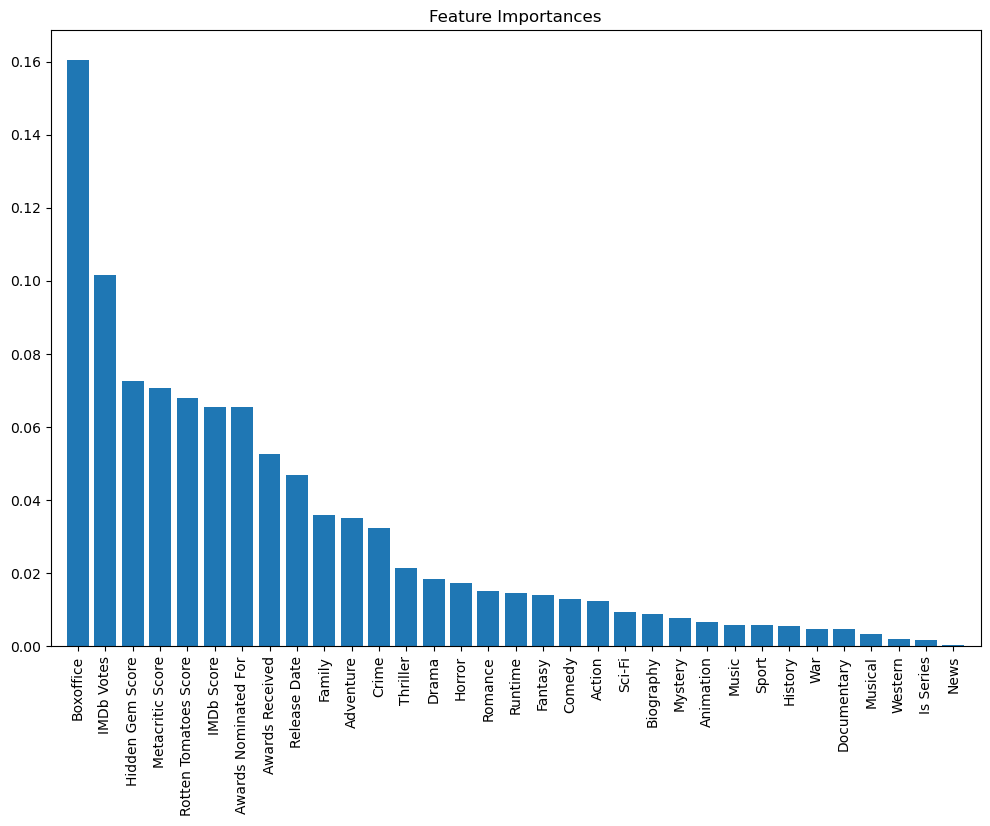

In [56]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(features.shape[1]), importances[indices], align="center")
plt.xticks(range(features.shape[1]), [features.columns[i] for i in indices], rotation=90)
plt.xlim([-1, features.shape[1]])
plt.show()

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# Identify unimportant features based on a threshold (e.g., importance < 0.01)
important_features_indices = indices[importances[indices] > 0.01]
important_features = features.columns[important_features_indices]

# Subset the features DataFrame to include only important features
X_important = features[important_features]

# Split the data into training and testing sets
X_train_important, X_test_important, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model with important features
rf_model_important = RandomForestClassifier(random_state=42)
rf_model_important.fit(X_train_important, y_train)

# Make predictions
y_pred_important = rf_model_important.predict(X_test_important)

# Evaluate the model
print("Accuracy (Important Features Only):", accuracy_score(y_test, y_pred_important))
print(classification_report(y_test, y_pred_important))

Accuracy (Important Features Only): 0.7151394422310757
              precision    recall  f1-score   support

       Adult       0.69      0.72      0.70       216
         All       0.73      0.55      0.63        58
        Teen       0.74      0.75      0.74       228

    accuracy                           0.72       502
   macro avg       0.72      0.67      0.69       502
weighted avg       0.72      0.72      0.71       502



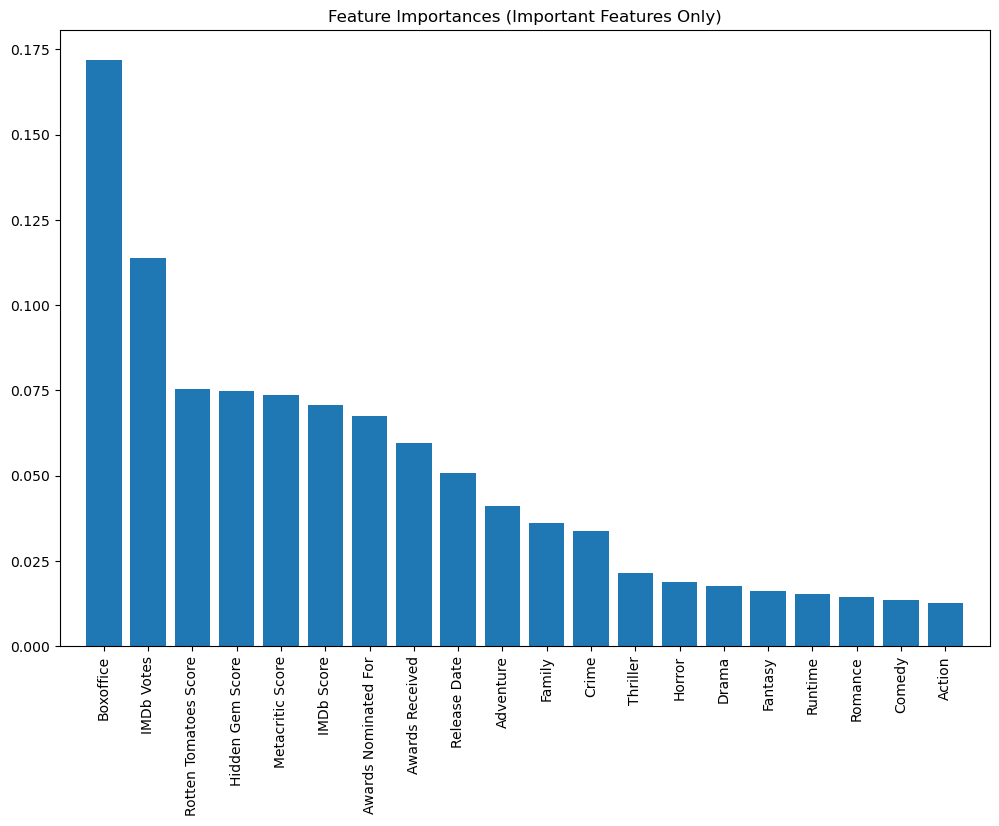

In [58]:
import numpy as np

import matplotlib.pyplot as plt

importances = rf_model_important.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Important Features Only)")
plt.bar(range(X_important.shape[1]), importances[indices], align="center")
plt.xticks(range(X_important.shape[1]), [important_features[i] for i in indices], rotation=90)
plt.xlim([-1, X_important.shape[1]])
plt.show()

In [59]:
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# ... (Load data and split into X_train, X_test, y_train, y_test as before)

# Define the parameter grid *without* n_estimators
param_grid = {
    'max_depth': [None, 10, 20],      
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]      
}

# Define the range of n_estimators to try
n_estimators_range = [50, 100, 200, 300]  # Expanded range

best_accuracy = 0
best_model = None
best_n_estimators = None
best_params = None

for n_estimators in n_estimators_range:
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42) # Fixed n_estimators for this inner loop

    n_train_samples = X_train.shape[0]  # Get the number of training samples

    halving_cv = HalvingGridSearchCV(
        rf_model, 
        param_grid, 
        cv=5,                
        resource='n_samples',  # Use n_samples as resource now!
        max_resources=int(n_train_samples * 0.5),      # 50% of training data as int
        factor=2,             
        min_resources=int(n_train_samples * 0.1),       # 10% of training data as int
        scoring='accuracy',   
        n_jobs=-1,           
        verbose=0             # Keep it quiet inside the loop
    )

    halving_cv.fit(X_train, y_train)

    best_inner_model = halving_cv.best_estimator_
    y_pred = best_inner_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = best_inner_model
        best_n_estimators = n_estimators
        best_params = halving_cv.best_params_

print("Best n_estimators:", best_n_estimators)
print("Best hyperparameters (other):", best_params)
print("Best Accuracy:", best_accuracy)
print(classification_report(y_test, best_model.predict(X_test)))

Best n_estimators: 100
Best hyperparameters (other): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.7151394422310757
              precision    recall  f1-score   support

       Adult       0.67      0.77      0.72       216
         All       0.73      0.52      0.61        58
        Teen       0.76      0.71      0.74       228

    accuracy                           0.72       502
   macro avg       0.72      0.67      0.69       502
weighted avg       0.72      0.72      0.71       502



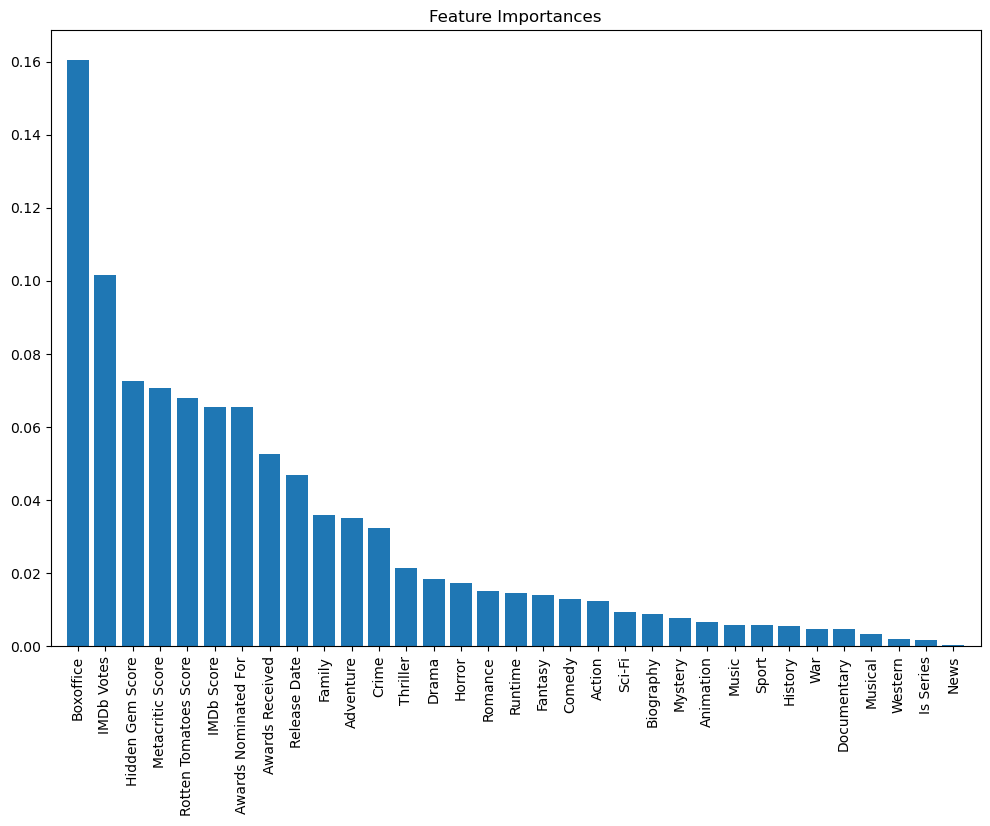

In [60]:
import numpy as np
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(features.shape[1]), importances[indices], align="center")
plt.xticks(range(features.shape[1]), [features.columns[i] for i in indices], rotation=90)
plt.xlim([-1, features.shape[1]])
plt.show()

In [61]:
# Convert 'Release Date' from Unix timestamp to datetime
time = pd.to_datetime(df['Release Date'], unit='s')

# Extract 'Release Year' and 'Release Month'
df['Release Year'] = time.dt.year
df['Release Month'] = time.dt.month


df[['Release Year', 'Release Month']]

,Release Year,Release Month
0,2021,3
1,2021,3
2,2021,3
3,2021,3
4,2021,3
...,...,...
2504,2015,4
2505,2015,4
2506,2015,4
2507,2015,4


In [62]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(features.shape[1]), importances[indices], align="center")
plt.xticks(range(features.shape[1]), [features.columns[i] for i in indices], rotation=90)
plt.xlim([-1, features.shape[1]])
plt.show()

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Without Month/Year\
Mean Absolute Error: 2.6508964143426295\
Mean Squared Error: 15.87341294820717\
R^2 Score: 0.42448857014852204\

With Month/Year\
Mean Absolute Error: 2.685258964143426\
Mean Squared Error: 16.079097609561753\
R^2 Score: 0.4170312026661205

In [ ]:
# import numpy as np

# import matplotlib.pyplot as plt

# # Get feature importances from the model
# importances = rf_model.feature_importances_
# indices = np.argsort(importances)[::-1]

# # Plot the feature importances
# plt.figure(figsize=(12, 8))
# plt.title("Feature Importances")
# plt.bar(range(X.shape[1]), importances[indices], align="center")
# plt.xticks(range(X.shape[1]), [feature_columns[i] for i in indices], rotation=90)
# plt.xlim([-1, X.shape[1]])
# plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline


# # Define the feature columns and target column
# feature_columns = ['Is Series', 'Hidden Gem Score', 'Release Year', 'Release Month', 'Runtime', 'IMDb Score', 'Rotten Tomatoes Score', 'Metacritic Score', 'Awards Received', 'Awards Nominated For', 'Boxoffice', 'Release Date', 'IMDb Votes', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']
# target_column = 'Minimum Age'

# # Separate the features and target variable
# X = df[feature_columns]
# y = df[target_column]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create the base Random Forest model
# rf_model = RandomForestRegressor(random_state=42)

# # Perform hyperparameter tuning with GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300],           # Number of trees
#     'max_depth': [10, 20, 30, None],           # Maximum depth of trees
#     'min_samples_split': [2, 5, 10],           # Minimum samples required to split
#     'min_samples_leaf': [1, 2, 4],             # Minimum samples per leaf node
#     'max_features': ['sqrt', 'log2', None],    # Number of features to consider at each split
# }
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Best model
# best_model = grid_search.best_estimator_

# # Make predictions
# y_pred = best_model.predict(X_test)

# # Evaluate the model
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Absolute Error: {mae}")
# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")

Normal with all\
Mean Absolute Error: 2.6771188598434255\
Mean squared Error: 15.796815884320345\
R^2 score: 0.4272656972795156

Without Release Year and Release Month\
Mean Absolute Error: 2.7117058956272846\
Mean Squared Error: 15.471498342231293\
R^2 Score: 0.4390605119431501

Without boxoffice
Mean Absolute Error: 2.880205843293493\
Mean Squared Error: 16.890488999557324\
R^2 Score: 0.38761314238197264

Without Genres
Mean Absolute Error: 3.13993962642096\
Mean Squared Error: 17.806074707839812\
R^2 Score: 0.35441738027053915

In [ ]:
# # Detailed results for all combinations
# cv_results = grid_search.cv_results_

# # Highlight the best parameters
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(f"Best Parameters: {best_params}")
# print(f"Best Cross-Validation R^2 Score: {best_score:.3f}")

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Extract data for plotting
# param_grid_combinations = [
#     (cv_results['param_n_estimators'][i],
#      cv_results['param_max_depth'][i] if cv_results['param_max_depth'][i] is not None else -1,  # Handle None
#      cv_results['mean_test_score'][i])
#     for i in range(len(cv_results['mean_test_score']))
# ]

# # Convert to numpy array for easier manipulation
# param_array = np.array(param_grid_combinations, dtype=object)

# # Reshape data for a specific hyperparameter relationship
# # Example: n_estimators vs. max_depth
# estimators = np.unique(param_array[:, 0])  # Unique n_estimators values
# depths = np.unique(param_array[:, 1])      # Unique max_depth values
# scores_matrix = np.zeros((len(estimators), len(depths)))

# # Fill the scores matrix
# for i, est in enumerate(estimators):
#     for j, dep in enumerate(depths):
#         score = param_array[(param_array[:, 0] == est) & (param_array[:, 1] == dep), 2]
#         scores_matrix[i, j] = score[0] if len(score) > 0 else np.nan

# # Heatmap of R^2 scores
# plt.figure(figsize=(8, 6))
# plt.imshow(scores_matrix, cmap='viridis', aspect='auto', extent=[min(depths), max(depths), min(estimators), max(estimators)])
# plt.colorbar(label='Mean R^2 Score')
# plt.xlabel('Max Depth (None = -1)')
# plt.ylabel('Number of Estimators')
# plt.title('GridSearchCV R^2 Scores')
# plt.show()


In [ ]:
# # Highlight the best parameters
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(f"Best Parameters: {best_params}")
# print(f"Best Cross-Validation R^2 Score: {best_score:.3f}")


In [ ]:
# # Predictions
# y_pred = best_model.predict(X_test)

# # Evaluation metrics
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Mean Absolute Error: {mae}")
# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")


In [ ]:
# # Residuals
# residuals = y_test - y_pred

# # Plot residuals
# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, residuals, alpha=0.6, edgecolor='k')
# plt.axhline(0, color='red', linestyle='--')
# plt.xlabel('Actual Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.show()


In [ ]:
# # Plot actual vs. predicted values
# plt.figure(figsize=(8, 6))
# plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted Values')
# plt.show()
